<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/CNN_augmentation_kfold_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is about 99 percent.


In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# select three classes only and limited number of events

N_TRAIN_EXAMPLES = 500
#N_TEST_EXAMPLES = 100
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES)
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES)
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

x_train = x_train[:N_TRAIN_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



170500096/170498071 [==============================] - 3s 0us/step
Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(500, 32, 32, 3)
(500, 1)
(3000, 32, 32, 3)
(3000, 1)


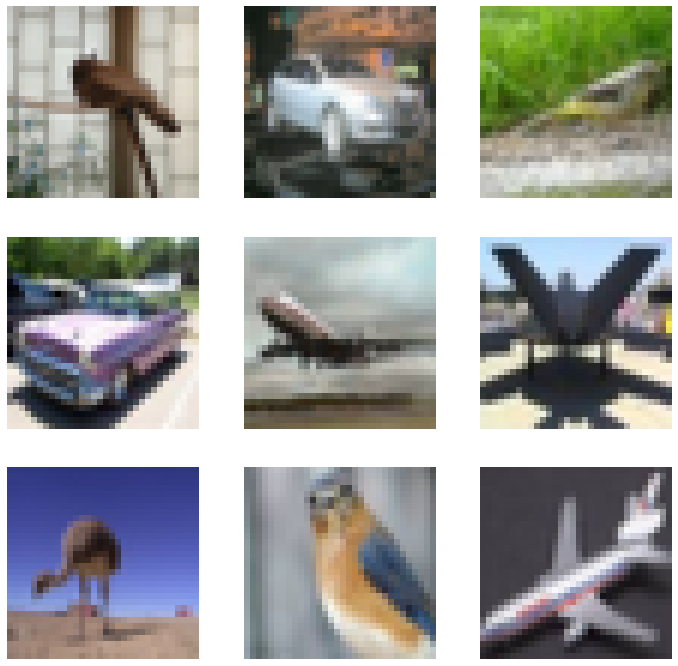

In [3]:
# save x_test images
xx_test = x_test
yy_test = y_test




fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    #print(x_train[i].shape)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25
    )
datagen.fit(x_train)

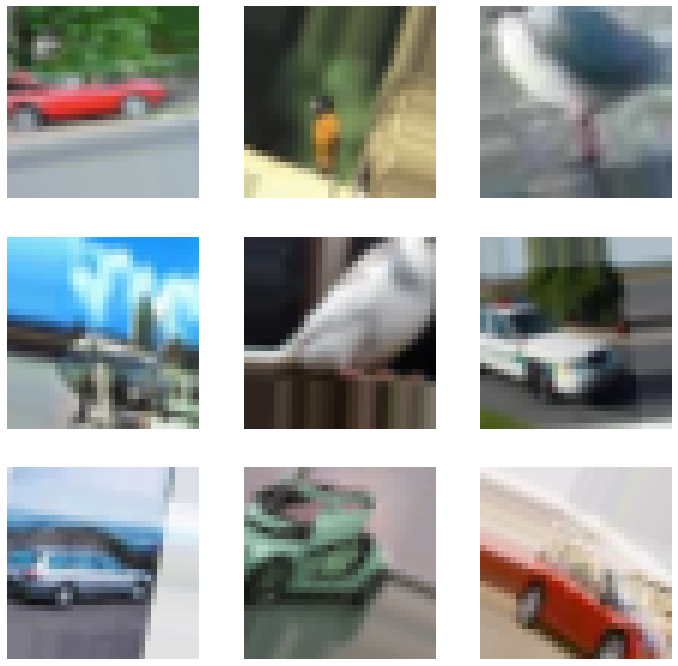

In [5]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
         plt.axis('off')
    plt.show()
    break

   

Augmentation of a single image

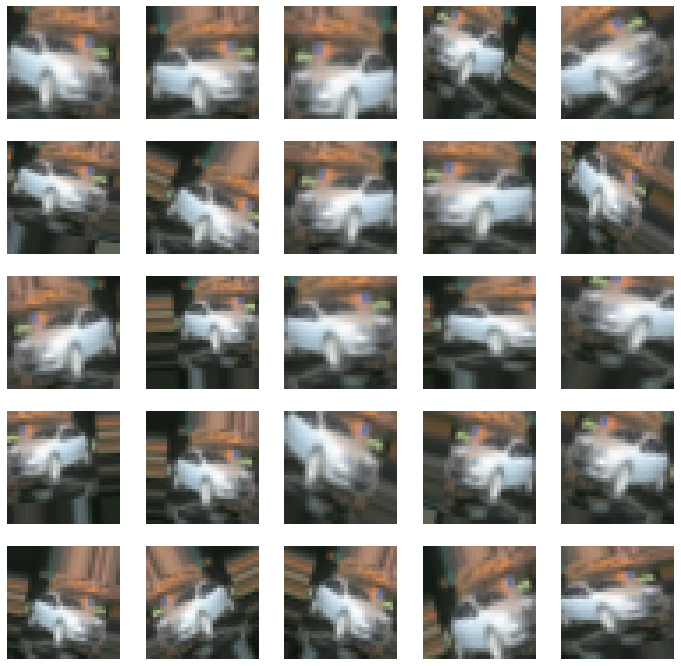

In [6]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()
    


In [7]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (500, 32, 32, 3)
500 train samples
3000 test samples


In [8]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [9]:
 # labels
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

In [10]:
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

# **TRAINING WITHOUT AUGMENTATION**

In [12]:
# training without augmentation

es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

history=model.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_test, y_test))

Epoch 1/150
4/4 [==============================] - 9s 289ms/step - loss: 1.5314 - accuracy: 0.4700 - val_loss: 1.0470 - val_accuracy: 0.5673
Epoch 2/150
4/4 [==============================] - 0s 61ms/step - loss: 0.6169 - accuracy: 0.8083 - val_loss: 1.0409 - val_accuracy: 0.5290
Epoch 3/150
4/4 [==============================] - 0s 60ms/step - loss: 0.2984 - accuracy: 0.8988 - val_loss: 1.0008 - val_accuracy: 0.5547
Epoch 4/150
4/4 [==============================] - 0s 62ms/step - loss: 0.2146 - accuracy: 0.9219 - val_loss: 1.0375 - val_accuracy: 0.4287
Epoch 5/150
4/4 [==============================] - 0s 103ms/step - loss: 0.1301 - accuracy: 0.9482 - val_loss: 1.1372 - val_accuracy: 0.4167
Epoch 6/150
4/4 [==============================] - 0s 61ms/step - loss: 0.0803 - accuracy: 0.9816 - val_loss: 1.2174 - val_accuracy: 0.4730
Epoch 7/150
4/4 [==============================] - 0s 60ms/step - loss: 0.0786 - accuracy: 0.9742 - val_loss: 1.3143 - val_accuracy: 0.4513
Epoch 8/150
4/4 [=

In [13]:
#training accuracy 
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

4/4 [==============================] - 0s 6ms/step - loss: 1.6028e-05 - accuracy: 1.0000


[1.6027928722905926e-05, 1.0]

In [14]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

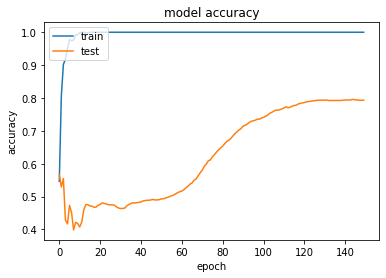

In [15]:
plothist(history)

In [16]:
#model.save('cifar10_01.h5')                  
#model=load_model('cifar10_01.h5')

In [17]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(N_CLASSES, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [18]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

# **TRAINING WITH DATA AUGMENTATION**

In [19]:
# train with image augmentation

es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=0
  )

history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_test, y_test))

Epoch 1/150
4/4 [==============================] - 2s 197ms/step - loss: 1.9650 - accuracy: 0.4628 - val_loss: 1.0678 - val_accuracy: 0.4917
Epoch 2/150
4/4 [==============================] - 0s 123ms/step - loss: 1.3783 - accuracy: 0.6034 - val_loss: 1.0563 - val_accuracy: 0.4510
Epoch 3/150
4/4 [==============================] - 0s 119ms/step - loss: 1.1235 - accuracy: 0.6315 - val_loss: 1.0718 - val_accuracy: 0.4450
Epoch 4/150
4/4 [==============================] - 0s 114ms/step - loss: 1.1060 - accuracy: 0.6421 - val_loss: 1.1629 - val_accuracy: 0.4387
Epoch 5/150
4/4 [==============================] - 0s 115ms/step - loss: 1.0496 - accuracy: 0.6565 - val_loss: 1.1958 - val_accuracy: 0.4290
Epoch 6/150
4/4 [==============================] - 0s 113ms/step - loss: 0.9602 - accuracy: 0.6403 - val_loss: 1.2391 - val_accuracy: 0.4153
Epoch 7/150
4/4 [==============================] - 0s 110ms/step - loss: 0.7384 - accuracy: 0.7243 - val_loss: 1.3634 - val_accuracy: 0.4143
Epoch 8/150
4

In [20]:
#model2.save('cifar10_02.h5')         # about 90% accuracy

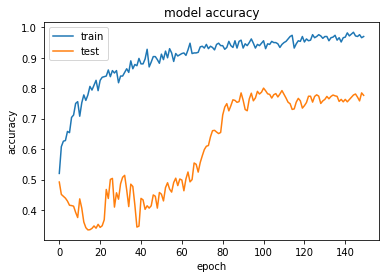

In [21]:
plothist(history2)  # 128 batch, 0.001 lr, 

In [22]:
print(x_test.shape,y_test.shape)
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

(3000, 32, 32, 3) (3000, 3)
24/24 [==============================] - 0s 6ms/step - loss: 1.0934 - accuracy: 0.7767


[1.0934288501739502, 0.7766666412353516]

In [23]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

4/4 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9920


[0.02238803170621395, 0.9919999837875366]

# **Plot images**

In [24]:
def plot_images(model2):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  y_pred = model2.predict_classes(x_test)
  y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


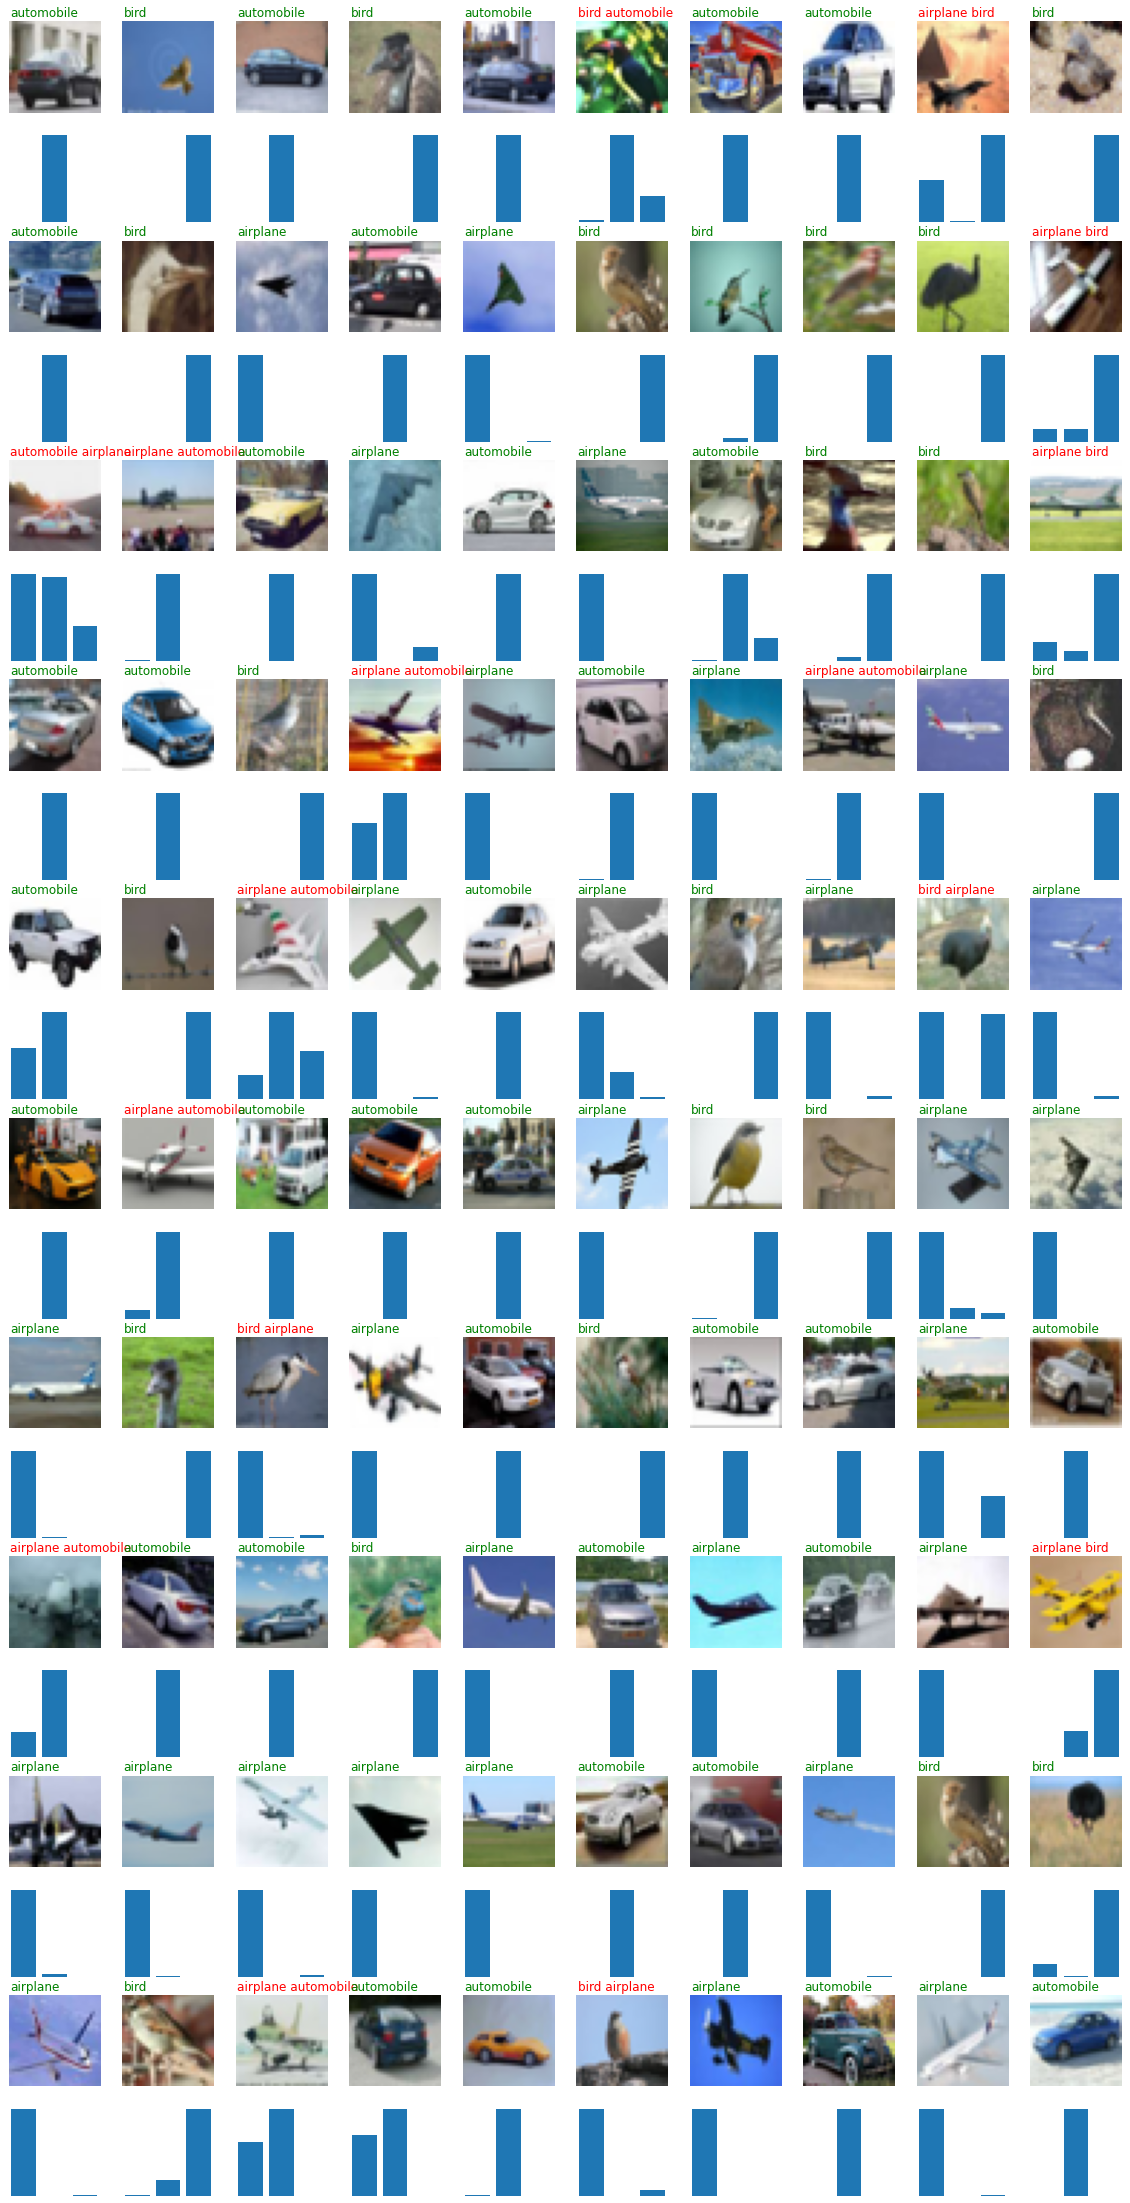

In [25]:
plot_images(model2)

In [26]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model2.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



94/94 - 0s
[[698 199 103]
 [ 36 951  13]
 [207 112 681]]


# **Optuna & K-FOLDING optimization**





In [27]:
def create_model(numfilters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [28]:
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  es = EarlyStopping(
    monitor="val_accuracy",
    patience=60,
    verbose=1
  )

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

In [29]:
# OPTUNA

! pip install optuna

import optuna

     |████████████████████████████████| 266kB 9.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 163kB 14.4MB/s 
     |████████████████████████████████| 112kB 14.5MB/s 
     |████████████████████████████████| 133kB 15.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=1bde7a898f332708f917d0a7d8cc22a267dd07d15b8921280fb6b0bcec7ba416
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=4457120805c3f427903a941fc835385743ed4d732894f632108e40394455dd39
  Stored in directory: /root/.cache/pip/whe

In [30]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=num_filters):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # create model
    model = create_model(num_filters)
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('Folding, acc =  %.3f' % (acc * 100.0))
		# stores scores
    scores.append(acc)
    histories.append(history)
    models.append(model)
  return scores, histories, models

# **Define objective**

In [31]:

def objective(trial):
    
    

    num_filters = int(trial.suggest_discrete_uniform("num_filters", 8,128,1))
    shift_range = trial.suggest_uniform('shift_range', .0,.4)
    rotation_range = trial.suggest_uniform('rotation_range', 0.,40.)

    # set up image augmentation
    datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
    )
    datagen.fit(x_train)


    #create and evaluate model
    scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

    return np.mean(scores)

In [32]:

study = optuna.create_study(direction='maximize',  sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=30)

study.best_params

[I 2020-12-24 14:23:00,268] A new study created in memory with name: no-name-91b0a968-a948-4468-837b-225c52412480


Folding, acc =  71.000
Folding, acc =  70.000
Folding, acc =  70.000
Folding, acc =  70.000


[I 2020-12-24 14:26:31,935] Trial 0 finished with value: 0.7079999923706055 and parameters: {'num_filters': 49.0, 'shift_range': 0.23960360078272225, 'rotation_range': 4.181219275219266}. Best is trial 0 with value: 0.7079999923706055.


Folding, acc =  73.000
Folding, acc =  72.000
Folding, acc =  84.000
Folding, acc =  73.000
Folding, acc =  70.000


[I 2020-12-24 14:30:00,462] Trial 1 finished with value: 0.7519999980926514 and parameters: {'num_filters': 30.0, 'shift_range': 0.11051923781278275, 'rotation_range': 7.75668263891482}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  77.000
Folding, acc =  81.000
Folding, acc =  77.000
Folding, acc =  71.000
Folding, acc =  71.000


[I 2020-12-24 14:33:31,233] Trial 2 finished with value: 0.7479999899864197 and parameters: {'num_filters': 55.0, 'shift_range': 0.2812400600884526, 'rotation_range': 28.45186703596436}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  74.000
Folding, acc =  65.000
Folding, acc =  75.000
Folding, acc =  75.000
Folding, acc =  68.000


[I 2020-12-24 14:36:59,355] Trial 3 finished with value: 0.7240000009536743 and parameters: {'num_filters': 105.0, 'shift_range': 0.11167271189429968, 'rotation_range': 8.588030790380813}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  79.000
Folding, acc =  74.000
Folding, acc =  77.000
Folding, acc =  73.000
Folding, acc =  77.000


[I 2020-12-24 14:40:26,153] Trial 4 finished with value: 0.7299999952316284 and parameters: {'num_filters': 56.0, 'shift_range': 0.018463909787067533, 'rotation_range': 12.158911134882038}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  64.000
Folding, acc =  73.000
Folding, acc =  75.000
Folding, acc =  69.000
Folding, acc =  75.000


[I 2020-12-24 14:43:53,675] Trial 5 finished with value: 0.7399999976158143 and parameters: {'num_filters': 102.0, 'shift_range': 0.11464355877251427, 'rotation_range': 15.24386344139062}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  78.000
Folding, acc =  74.000
Folding, acc =  68.000
Folding, acc =  65.000
Folding, acc =  72.000


[I 2020-12-24 14:47:25,295] Trial 6 finished with value: 0.7020000100135804 and parameters: {'num_filters': 46.0, 'shift_range': 0.3860171125329133, 'rotation_range': 4.678093408984565}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  72.000
Folding, acc =  75.000
Folding, acc =  67.000
Folding, acc =  67.000
Folding, acc =  71.000


[I 2020-12-24 14:50:55,891] Trial 7 finished with value: 0.7040000081062316 and parameters: {'num_filters': 60.0, 'shift_range': 0.3415294191615563, 'rotation_range': 4.375605864870713}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  72.000
Folding, acc =  70.000
Folding, acc =  73.000
Folding, acc =  72.000
Folding, acc =  82.000


[I 2020-12-24 14:54:30,252] Trial 8 finished with value: 0.7380000114440918 and parameters: {'num_filters': 127.0, 'shift_range': 0.0691244713371892, 'rotation_range': 4.525351420561896}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  72.000
Folding, acc =  73.000
Folding, acc =  73.000
Folding, acc =  75.000
Folding, acc =  76.000


[I 2020-12-24 14:58:00,922] Trial 9 finished with value: 0.7340000033378601 and parameters: {'num_filters': 32.0, 'shift_range': 0.006220428669456091, 'rotation_range': 30.21582062312641}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  70.000
Folding, acc =  77.000
Folding, acc =  68.000
Folding, acc =  64.000
Folding, acc =  71.000


[I 2020-12-24 15:01:34,747] Trial 10 finished with value: 0.693999993801117 and parameters: {'num_filters': 16.0, 'shift_range': 0.17400895735770505, 'rotation_range': 39.72760024084692}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  67.000
Folding, acc =  74.000
Folding, acc =  69.000
Folding, acc =  59.000
Folding, acc =  77.000


[I 2020-12-24 15:05:09,078] Trial 11 finished with value: 0.699999988079071 and parameters: {'num_filters': 10.0, 'shift_range': 0.28166832907839723, 'rotation_range': 26.670959275327803}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  71.000
Folding, acc =  77.000
Folding, acc =  70.000
Folding, acc =  68.000
Folding, acc =  70.000


[I 2020-12-24 15:08:40,806] Trial 12 finished with value: 0.6979999899864197 and parameters: {'num_filters': 87.0, 'shift_range': 0.1933357392611333, 'rotation_range': 23.34823624227723}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  64.000
Folding, acc =  79.000
Folding, acc =  75.000
Folding, acc =  65.000
Folding, acc =  72.000


[I 2020-12-24 15:12:13,399] Trial 13 finished with value: 0.7200000047683716 and parameters: {'num_filters': 28.0, 'shift_range': 0.2965923065895124, 'rotation_range': 35.04366896487135}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  69.000
Folding, acc =  71.000
Folding, acc =  78.000
Folding, acc =  71.000
Folding, acc =  77.000


[I 2020-12-24 15:15:44,580] Trial 14 finished with value: 0.7459999799728394 and parameters: {'num_filters': 80.0, 'shift_range': 0.147088875698238, 'rotation_range': 18.380967350488422}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  76.000
Folding, acc =  74.000
Folding, acc =  74.000
Folding, acc =  67.000
Folding, acc =  71.000


[I 2020-12-24 15:19:16,825] Trial 15 finished with value: 0.7120000004768372 and parameters: {'num_filters': 35.0, 'shift_range': 0.2429203562098055, 'rotation_range': 29.69102729974921}. Best is trial 1 with value: 0.7519999980926514.


Folding, acc =  70.000
Folding, acc =  73.000
Folding, acc =  73.000
Folding, acc =  80.000
Folding, acc =  83.000


[I 2020-12-24 15:22:45,902] Trial 16 finished with value: 0.7620000123977662 and parameters: {'num_filters': 18.0, 'shift_range': 0.05952072013638937, 'rotation_range': 21.34750374964446}. Best is trial 16 with value: 0.7620000123977662.


Folding, acc =  72.000
Folding, acc =  70.000
Folding, acc =  73.000
Folding, acc =  76.000
Folding, acc =  77.000


[I 2020-12-24 15:26:15,448] Trial 17 finished with value: 0.7399999976158143 and parameters: {'num_filters': 10.0, 'shift_range': 0.05591070082505733, 'rotation_range': 20.940081944891105}. Best is trial 16 with value: 0.7620000123977662.


Folding, acc =  74.000
Folding, acc =  84.000
Folding, acc =  68.000
Folding, acc =  74.000
Folding, acc =  82.000


[I 2020-12-24 15:29:43,561] Trial 18 finished with value: 0.7659999966621399 and parameters: {'num_filters': 15.0, 'shift_range': 0.07358584789741607, 'rotation_range': 12.184611558083187}. Best is trial 18 with value: 0.7659999966621399.


Folding, acc =  75.000
Folding, acc =  72.000
Folding, acc =  73.000
Folding, acc =  72.000
Folding, acc =  75.000


[I 2020-12-24 15:33:13,436] Trial 19 finished with value: 0.7320000171661377 and parameters: {'num_filters': 18.0, 'shift_range': 0.04863775826651942, 'rotation_range': 15.281855301972378}. Best is trial 18 with value: 0.7659999966621399.


Folding, acc =  74.000
Folding, acc =  70.000
Folding, acc =  79.000
Folding, acc =  71.000
Folding, acc =  70.000


[I 2020-12-24 15:36:42,055] Trial 20 finished with value: 0.7099999904632568 and parameters: {'num_filters': 71.0, 'shift_range': 0.003604088739840444, 'rotation_range': 23.520017880430043}. Best is trial 18 with value: 0.7659999966621399.


Folding, acc =  65.000
Folding, acc =  76.000
Folding, acc =  78.000
Folding, acc =  77.000
Folding, acc =  77.000


[I 2020-12-24 15:40:11,264] Trial 21 finished with value: 0.7759999871253968 and parameters: {'num_filters': 23.0, 'shift_range': 0.09507193778262894, 'rotation_range': 9.574805497958659}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  80.000
Folding, acc =  70.000
Folding, acc =  81.000
Folding, acc =  74.000
Folding, acc =  82.000


[I 2020-12-24 15:43:36,809] Trial 22 finished with value: 0.7679999947547913 and parameters: {'num_filters': 8.0, 'shift_range': 0.07782617608951611, 'rotation_range': 0.30266614679144155}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  77.000
Folding, acc =  71.000
Folding, acc =  69.000
Folding, acc =  71.000
Folding, acc =  74.000


[I 2020-12-24 15:47:02,978] Trial 23 finished with value: 0.7019999980926513 and parameters: {'num_filters': 8.0, 'shift_range': 0.09573133441425202, 'rotation_range': 1.3752677051854953}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  66.000
Folding, acc =  82.000
Folding, acc =  77.000
Folding, acc =  66.000
Folding, acc =  79.000


[I 2020-12-24 15:50:30,045] Trial 24 finished with value: 0.7580000042915345 and parameters: {'num_filters': 23.0, 'shift_range': 0.15777877261087472, 'rotation_range': 0.2997041119622343}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  75.000
Folding, acc =  74.000
Folding, acc =  79.000
Folding, acc =  64.000
Folding, acc =  72.000


[I 2020-12-24 15:53:54,833] Trial 25 finished with value: 0.7260000109672546 and parameters: {'num_filters': 40.0, 'shift_range': 0.03514440661864217, 'rotation_range': 10.459178693826615}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  74.000
Folding, acc =  75.000
Folding, acc =  84.000
Folding, acc =  68.000
Folding, acc =  69.000


[I 2020-12-24 15:57:21,382] Trial 26 finished with value: 0.7379999995231629 and parameters: {'num_filters': 13.0, 'shift_range': 0.14096767314189435, 'rotation_range': 13.599199416156118}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  73.000
Folding, acc =  80.000
Folding, acc =  76.000
Folding, acc =  78.000
Folding, acc =  77.000


[I 2020-12-24 16:00:47,739] Trial 27 finished with value: 0.7659999966621399 and parameters: {'num_filters': 23.0, 'shift_range': 0.08417942493601833, 'rotation_range': 17.301427679684096}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  72.000
Folding, acc =  83.000
Folding, acc =  81.000
Folding, acc =  67.000
Folding, acc =  74.000


[I 2020-12-24 16:04:14,600] Trial 28 finished with value: 0.7420000076293946 and parameters: {'num_filters': 25.0, 'shift_range': 0.09205548551017667, 'rotation_range': 17.49829701389917}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  66.000
Folding, acc =  75.000
Folding, acc =  77.000
Folding, acc =  76.000
Folding, acc =  73.000


[I 2020-12-24 16:07:42,267] Trial 29 finished with value: 0.7519999980926514 and parameters: {'num_filters': 41.0, 'shift_range': 0.21654923930604483, 'rotation_range': 7.5186166419363865}. Best is trial 21 with value: 0.7759999871253968.


Folding, acc =  75.000


{'num_filters': 23.0,
 'rotation_range': 9.574805497958659,
 'shift_range': 0.09507193778262894}

In [33]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Number of finished trials: 30
Best trial:
  Value: 0.7759999871253968
  Params: 
    num_filters: 23.0
    shift_range: 0.09507193778262894
    rotation_range: 9.574805497958659


# **Train with optimized parameters**

In [34]:




# CREATE MORE IMAGES VIA DATA AUGMENTATION
#  rotation_range = trial.suggest_uniform('rotation_range', .00,30)
#  zoom_range = trial.suggest_uniform('zoom_range', .00,0.30)
#  shift_range = trial.suggest_uniform('shift_range', .00,0.20)

num_filters = trial.params.get('num_filters')
rotation_range = trial.params.get('rotation_range')
shift_range = trial.params.get('shift_range')


# set up image augmentation
datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
)
datagen.fit(x_train)


#create and evaluate model
scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

Folding, acc =  72.000
Folding, acc =  85.000
Folding, acc =  76.000
Folding, acc =  81.000
Folding, acc =  74.000


# **Make plots**

In [35]:
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

# **Summarize**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



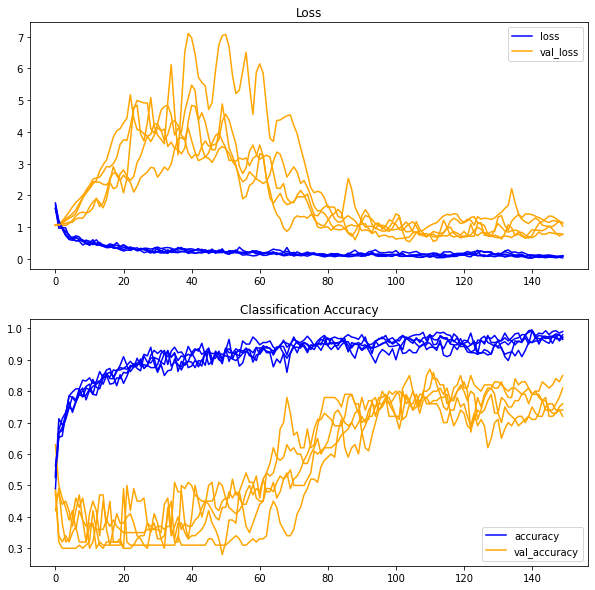

Accuracy: mean=77.600 std=4.758, n=5


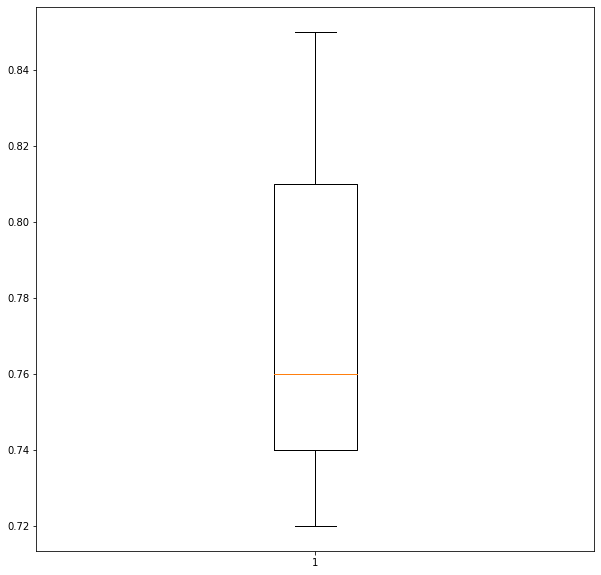

Scores:  [0.7200000286102295, 0.8500000238418579, 0.7599999904632568, 0.8100000023841858, 0.7400000095367432]


In [36]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

# **Ensamble of networks**

In [37]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)


score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  81.73333333333333 %


In [38]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix


#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[768 173  59]
 [ 29 965   6]
 [134 147 719]]


# **Plot images**

In [39]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


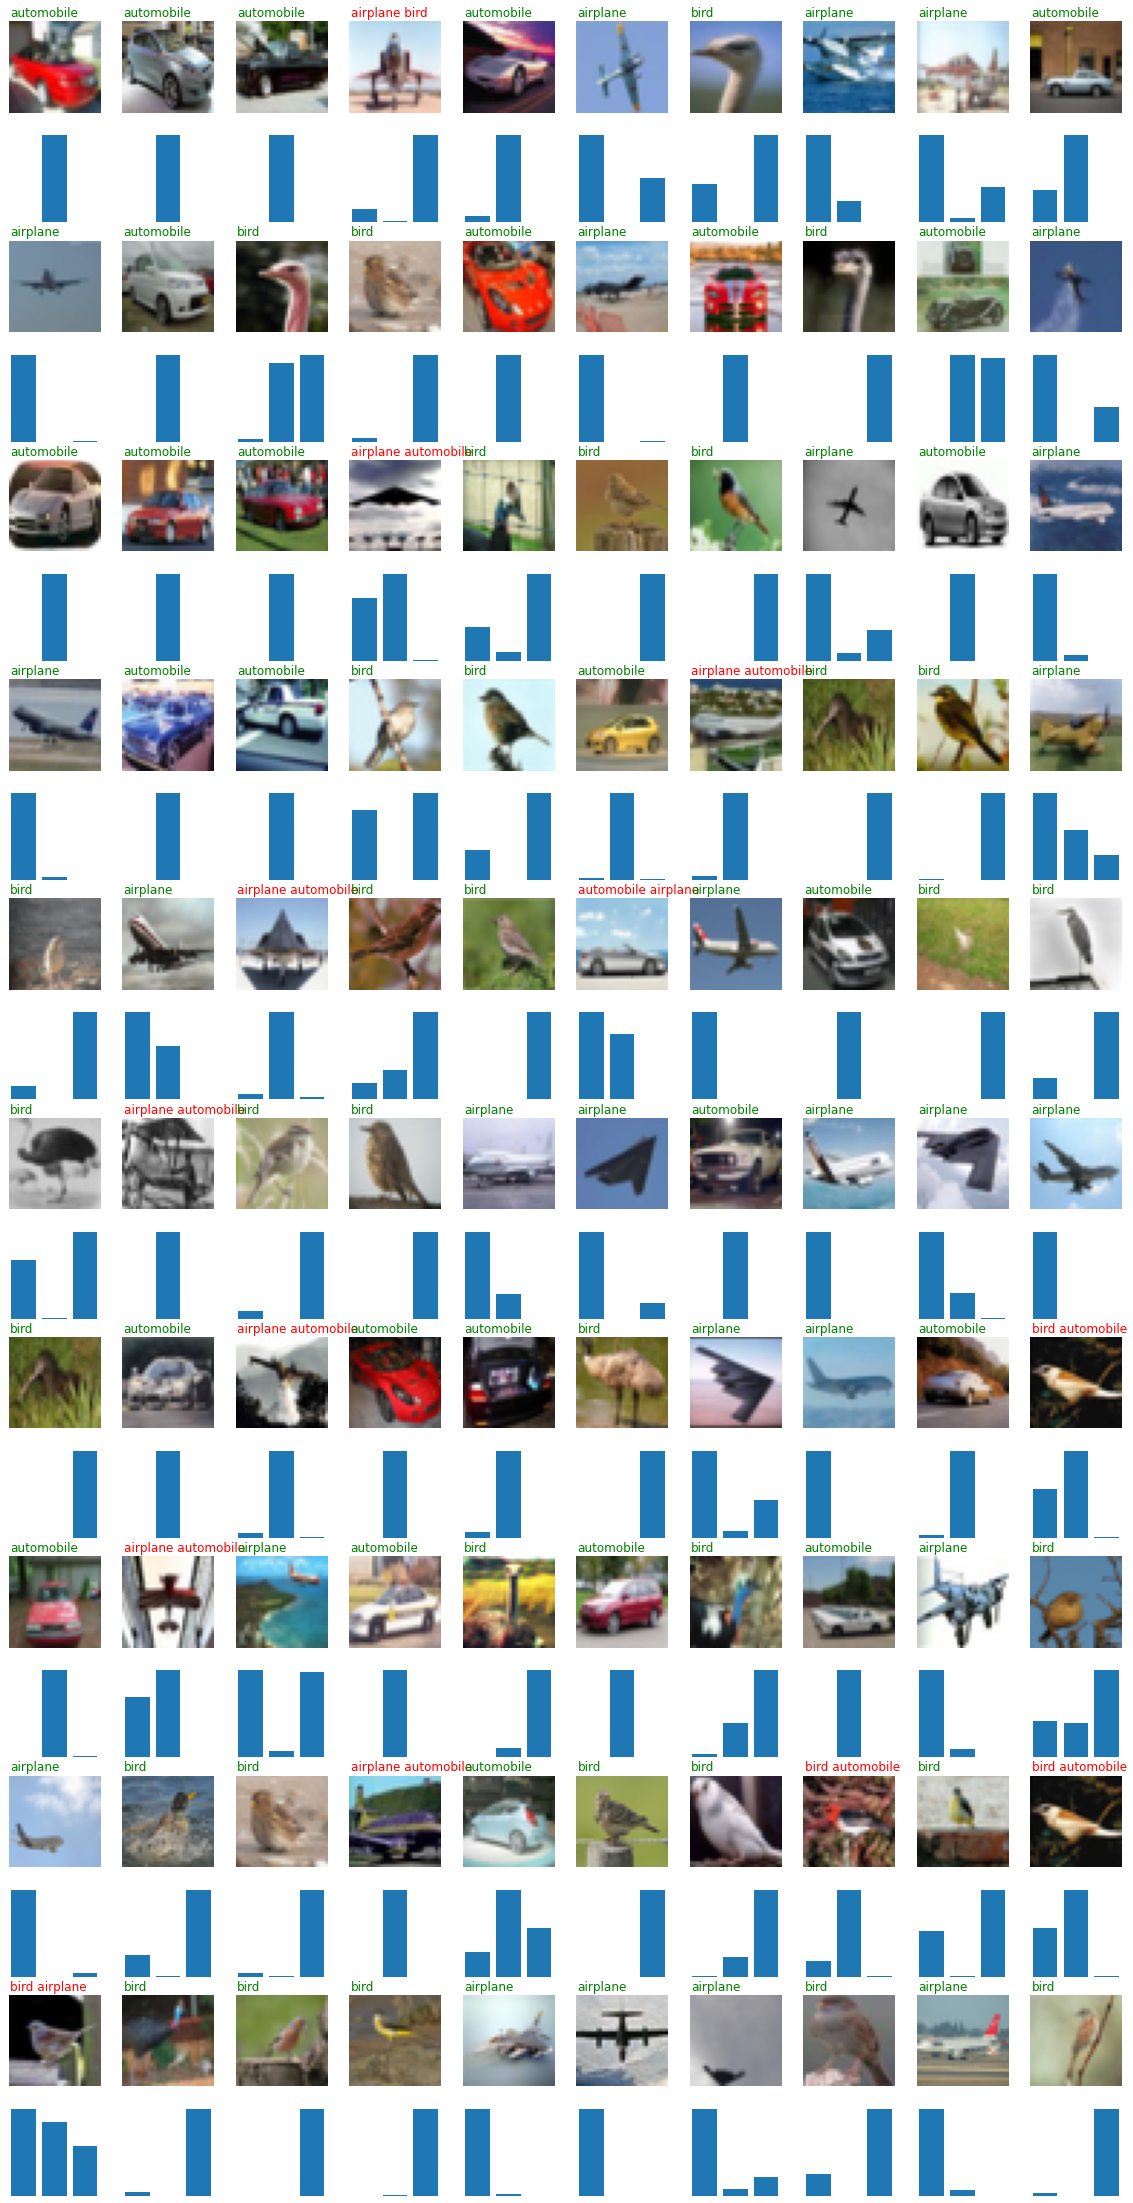

In [40]:
plot_images2(outcomes,summed)

## Visualizing the Optimization History

In [41]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [42]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [43]:
from optuna.visualization import plot_contour

plot_contour(study)

## Visualizing Individual Parameters

In [44]:
from optuna.visualization import plot_slice

plot_slice(study)

## Visualizing Parameter Importances

In [45]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)